In [1]:
import sys
sys.path.append("..")
from multiprocessing import Pool
import numpy as np
from graph import Circle, Grid, RandomRegular, GraphByDegrees, ErdosRenyi, ScaleFree, SmallWorld, move_assortativity
from viz import draw_data
from utils import Timer, partition
from engine import fun
from engine_single import fun_single
from graph_toolset import coreness, degs
import jupyternotify
import random
import matplotlib.cm as cm
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

# from scipy.misc import imresize
"""
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
"""
import matplotlib.pyplot as plt


from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

import pickle

%matplotlib notebook

<IPython.core.display.Javascript object>

In [2]:
def total(graph, keys):
    res = dict()
    if 'rho' in keys:
        res['rho'] = graph.nodes()
    return res

In [3]:
def addr(filename):
    return '/home/zhuk1996/data/' + filename + '.pkl'

In [4]:
def calc(fun_name, alphas, bs, graphs, T, out_file, init_type='01', keys=['rho'], set_builder=total, pool_size=32):
    pool = Pool(pool_size)
    
    res = dict()
    for key in keys:
        res[key] = []

    timer = Timer()
    
    now = 0
    
    for graph in graphs:
        local_timer = Timer()
        
        sets = set_builder(graph, keys)
        
        points = [(graph, b, alpha, T, init_type, sets) for alpha in alphas for b in bs]
        
        if fun_name == 'fun':
            cur = pool.map(fun, points)
        elif fun_name == 'mono':
            cur = pool.map(fun_mono, points)
        elif fun_name == 'sum':
            cur = pool.map(fun_sum, points)
        elif fun_name == 'tot':
            cur = pool.map(fun_tot, points)
        elif fun_name == 'single':
            cur = pool.map(fun_single, points)
        else:
            raise Exception(f'dont know fun name {fun_name}!')
        
        for key in keys:
            tmp = []
            for step in cur:
                tmp.append(step[key])
            
            tmp = np.array(tmp)
            tmp = np.reshape(tmp, (len(alphas), len(bs), tmp.shape[1]))
            res[key].append(tmp)
        
        t = local_timer.measure()
        now += 1
        # rem = len(graphs) - now
        # print(f'#{now} passed in {local_timer.measure()},  projected end in {timer.measure() / now * rem / 60} minutes', flush=True)
        
    for key in keys:
        res[key] = np.array(res[key])
        
    timer.print_elapsed()
    
    with open(addr(out_file), 'wb') as f:
        pickle.dump(res, f)
    
    print(f'Written to {addr(out_file)}')
    

In [5]:
def cut_alpha(data, alpha_id):
    res = dict()
    for key, arr in data.items():
        res[key] = arr[:, alpha_id, :, :]
    return res

In [6]:
def plot_means(bs, data, last, keys, title, show_data=False):
    fig, ax = plt.subplots()
    
    for key in keys:
        cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
        if show_data:
            for t in cur:
                ax.scatter(bs, t, s=1, alpha=.5)

        cur = np.apply_along_axis(np.mean, 0, cur)
        # cur = np.apply_along_axis(np.median, 0, cur)
        ax.plot(bs, cur, '-', label=f'{key}')
    # ax.legend()
    ax.set_title(title)
    plt.show()

In [7]:
def single(bs, filename, last, keys, name, show_data=True):
    fig, ax = plt.subplots(figsize=(3 * 3, 2.5 * 2))
    plt.locator_params(axis='y', nbins=5)
    plt.locator_params(axis='x', nbins=11)
    
    with open(addr(filename), 'rb') as f:
        data = cut_alpha(pickle.load(f), 0)
        
        for key in keys:
            if key.startswith('std'):
                cur = np.apply_along_axis(np.std, 2, data[key[3:]][:, :, -last:])
            else:
                cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
            if show_data:
                for t in cur:
                    ax.scatter(bs, t, s=1, alpha=.2, c='red')

            cur = np.apply_along_axis(np.mean, 0, cur)
            # cur = np.apply_along_axis(np.median, 0, cur)
            ax.plot(bs, cur, '-', label=f'{key}')
        for i in range(1, 17):
            ax.axvline(x=i,c='black',linestyle='--',linewidth=.2)
        ax.set_xlabel(r'$b$')
        ax.set_ylabel(r'$\rho$')
        ax.set_title(name)

    plt.show()

In [8]:
def plot_2d(bs, filenames, last, keys, names, show_data=True):
    fig, grid = plt.subplots(nrows=2, ncols=3, figsize=(3 * 3, 2.5 * 2), sharex=True, sharey=True)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.2)
    plt.locator_params(axis='y', nbins=5)
    plt.locator_params(axis='x', nbins=10)
    
    for name, filename, s in zip(names, filenames, range(len(names))):
        with open(addr(filename), 'rb') as f:
            data = cut_alpha(pickle.load(f), 0)
        
        i = s // 3
        j = s % 3
        
        ax = grid[i][j]
        
        for key in keys:
            if key.startswith('std'):
                cur = np.apply_along_axis(np.std, 2, data[key[3:]][:, :, -last:])
            else:
                cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
            if show_data:
                for t in cur:
                    ax.scatter(bs, t, s=1, alpha=.5, c='red')

            cur = np.apply_along_axis(np.mean, 0, cur)
            # cur = np.apply_along_axis(np.median, 0, cur)
            ax.plot(bs, cur, '-', label=f'{key}')
        # ax.legend()
        if j == 0:
            ax.set_ylabel(r'$\rho$')
        if i == 1:
            ax.set_xlabel(r'$b$')
        ax.set_title(name)

    plt.show()

In [9]:
def plot_of_prefix(prefix, draw):
    names = [prefix + suffix for suffix in ['_er', '_sf', '_ws', '_two', '_three', '_four']]
    plot_2d(bs, names, draw, ['rho'], ['ER', 'SF', 'WS', 'R2', 'R3', 'R4'])

In [10]:
def print_info(filename):
    with open(addr(filename), 'rb') as f:
            data = pickle.load(f)
            print(data['rho'].shape)

In [11]:
bs = partition(1, 10, 64)
alphas = [.1]
n = 1000
cnt = 100
print(bs)
print(alphas)

[ 1.140625  1.28125   1.421875  1.5625    1.703125  1.84375   1.984375
  2.125     2.265625  2.40625   2.546875  2.6875    2.828125  2.96875
  3.109375  3.25      3.390625  3.53125   3.671875  3.8125    3.953125
  4.09375   4.234375  4.375     4.515625  4.65625   4.796875  4.9375
  5.078125  5.21875   5.359375  5.5       5.640625  5.78125   5.921875
  6.0625    6.203125  6.34375   6.484375  6.625     6.765625  6.90625
  7.046875  7.1875    7.328125  7.46875   7.609375  7.75      7.890625
  8.03125   8.171875  8.3125    8.453125  8.59375   8.734375  8.875
  9.015625  9.15625   9.296875  9.4375    9.578125  9.71875   9.859375
 10.      ]
[0.1]


In [12]:
def ER(t):
    return ErdosRenyi(*t)

def SF(t):
    return ScaleFree(*t)

def WS(t):
    return SmallWorld(*t)

def er_graphs(cnt, by=0):
    for _ in range(cnt):
        graph = ErdosRenyi(n, 5. / n)
        move_assortativity(graph, by)
        yield graph

def sf_graphs(cnt):
    for _ in range(cnt):
        yield ScaleFree(n, 5)

def ws_graphs(cnt):
    for _ in range(cnt):
        yield SmallWorld(n, 5, .5)
    
def r_graphs(cnt, degs, by=0):
    for _ in range(cnt):
        graph = GraphByDegrees(degs)
        move_assortativity(graph, by)
        yield graph
        

In [13]:
def run_and_draw(name, fun, graphs, steps, draw, picname):
    timer = Timer()    
    calc(fun, alphas, bs, graphs, steps, name)
    print(f'overall time = {timer.measure() / 60} mins')
    single(bs, name, draw, ['rho'], picname)

In [14]:
def several(bs, filenames, last, names, keys=['rho']):
    fig, ax = plt.subplots(figsize=(3 * 3, 2.5 * 2))
    plt.locator_params(axis='y', nbins=5)
    plt.locator_params(axis='x', nbins=11)
    
    for filename, name in zip(filenames, names):
        with open(addr(filename), 'rb') as f:
            data = cut_alpha(pickle.load(f), 0)

            for key in keys:
                if key.startswith('std'):
                    cur = np.apply_along_axis(np.std, 2, data[key[3:]][:, :, -last:])
                else:
                    cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])

                cur = np.apply_along_axis(np.mean, 0, cur)
                # cur = np.apply_along_axis(np.median, 0, cur)
                ax.plot(bs, cur, '-', label=name)
            for i in range(1, 17):
                ax.axvline(x=i,c='black',linestyle='--',linewidth=.2)
            
            # ax.set_title(name)
                
    ax.set_xlabel(r'$b$')
    ax.set_ylabel(r'$\rho$')
    ax.legend()
    
    plt.show()

time elapsed = 518.8555507659912
Written to /home/zhuk1996/data/er_single.pkl
overall time = 8.654290302594502 mins


<IPython.core.display.Javascript object>


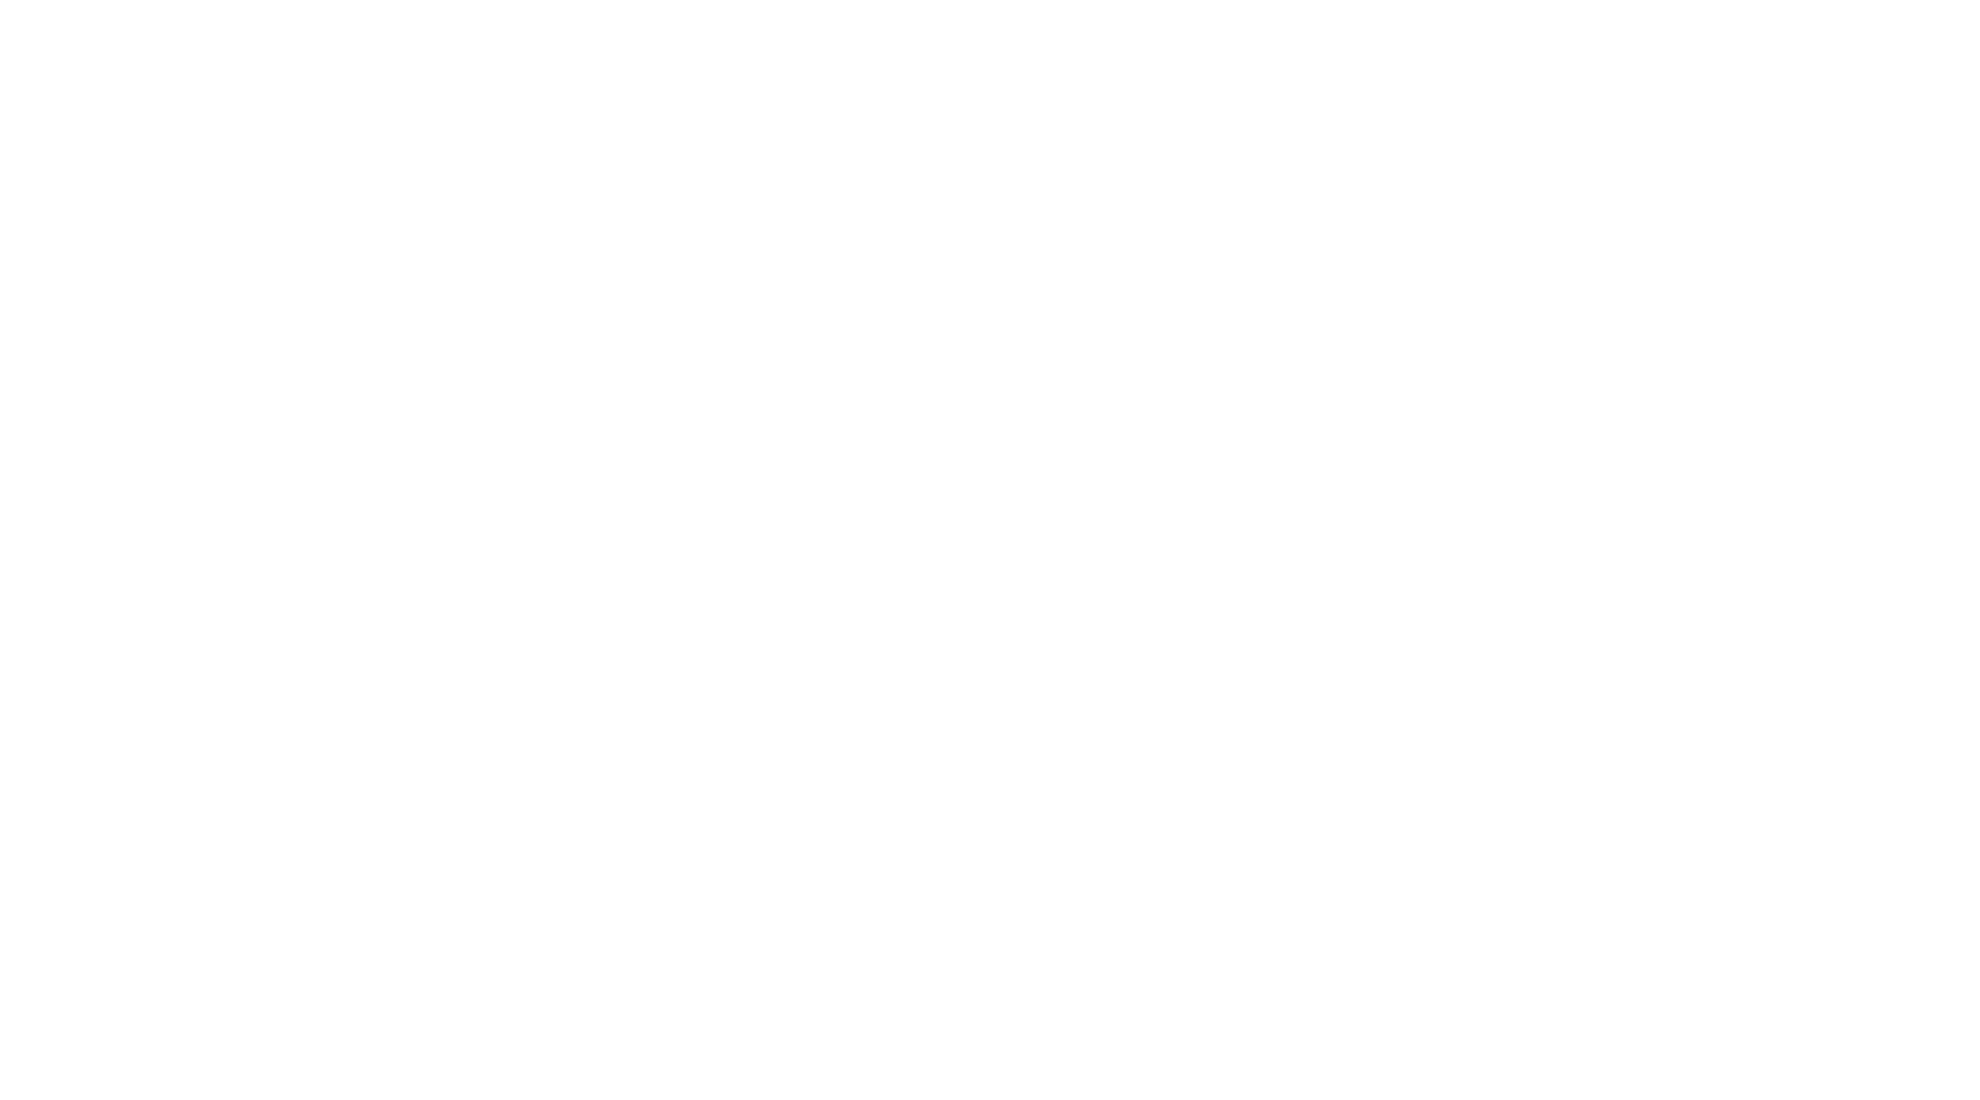

In [16]:
run_and_draw('er_single', 'single', er_graphs(10), 1000, 200, 'Single')

In [20]:
run_and_draw('er_diverse', 'fun', er_graphs(10), 1000, 200, 'Diverse')

time elapsed = 636.4465763568878
Written to /home/zhuk1996/data/er_diverse.pkl
overall time = 10.613640773296357 mins


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


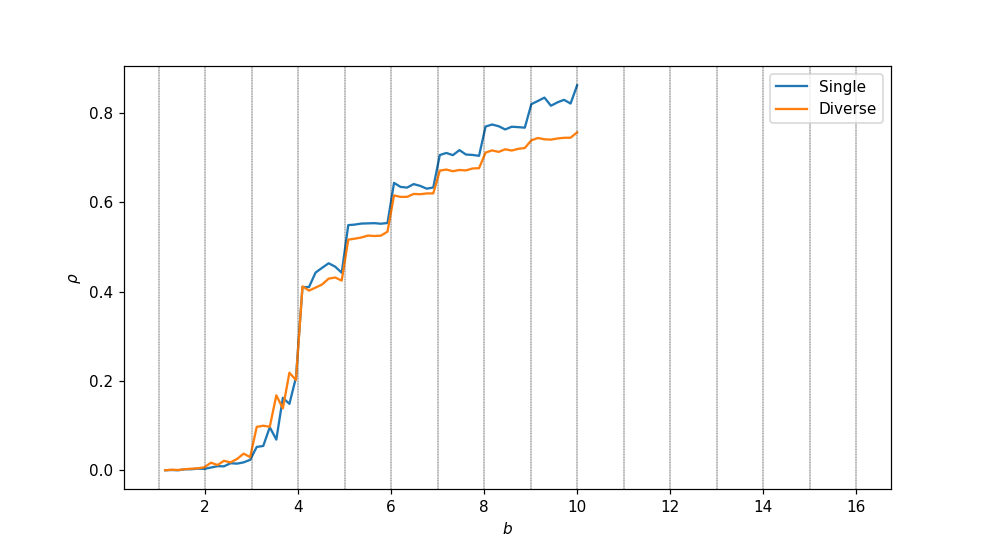

In [15]:
several(bs, ['er_single', 'er_diverse'], 200, ['Single', 'Diverse'])

In [22]:
run_and_draw('r2_single', 'single', r_graphs(10, {2 : 300}), 1000, 200, 'R2')

time elapsed = 100.94580841064453
Written to /home/zhuk1996/data/r2_single.pkl
overall time = 1.6882495443026224 mins


<IPython.core.display.Javascript object>

time elapsed = 118.10592198371887
Written to /home/zhuk1996/data/r3_single.pkl
overall time = 1.9745689511299134 mins


<IPython.core.display.Javascript object>


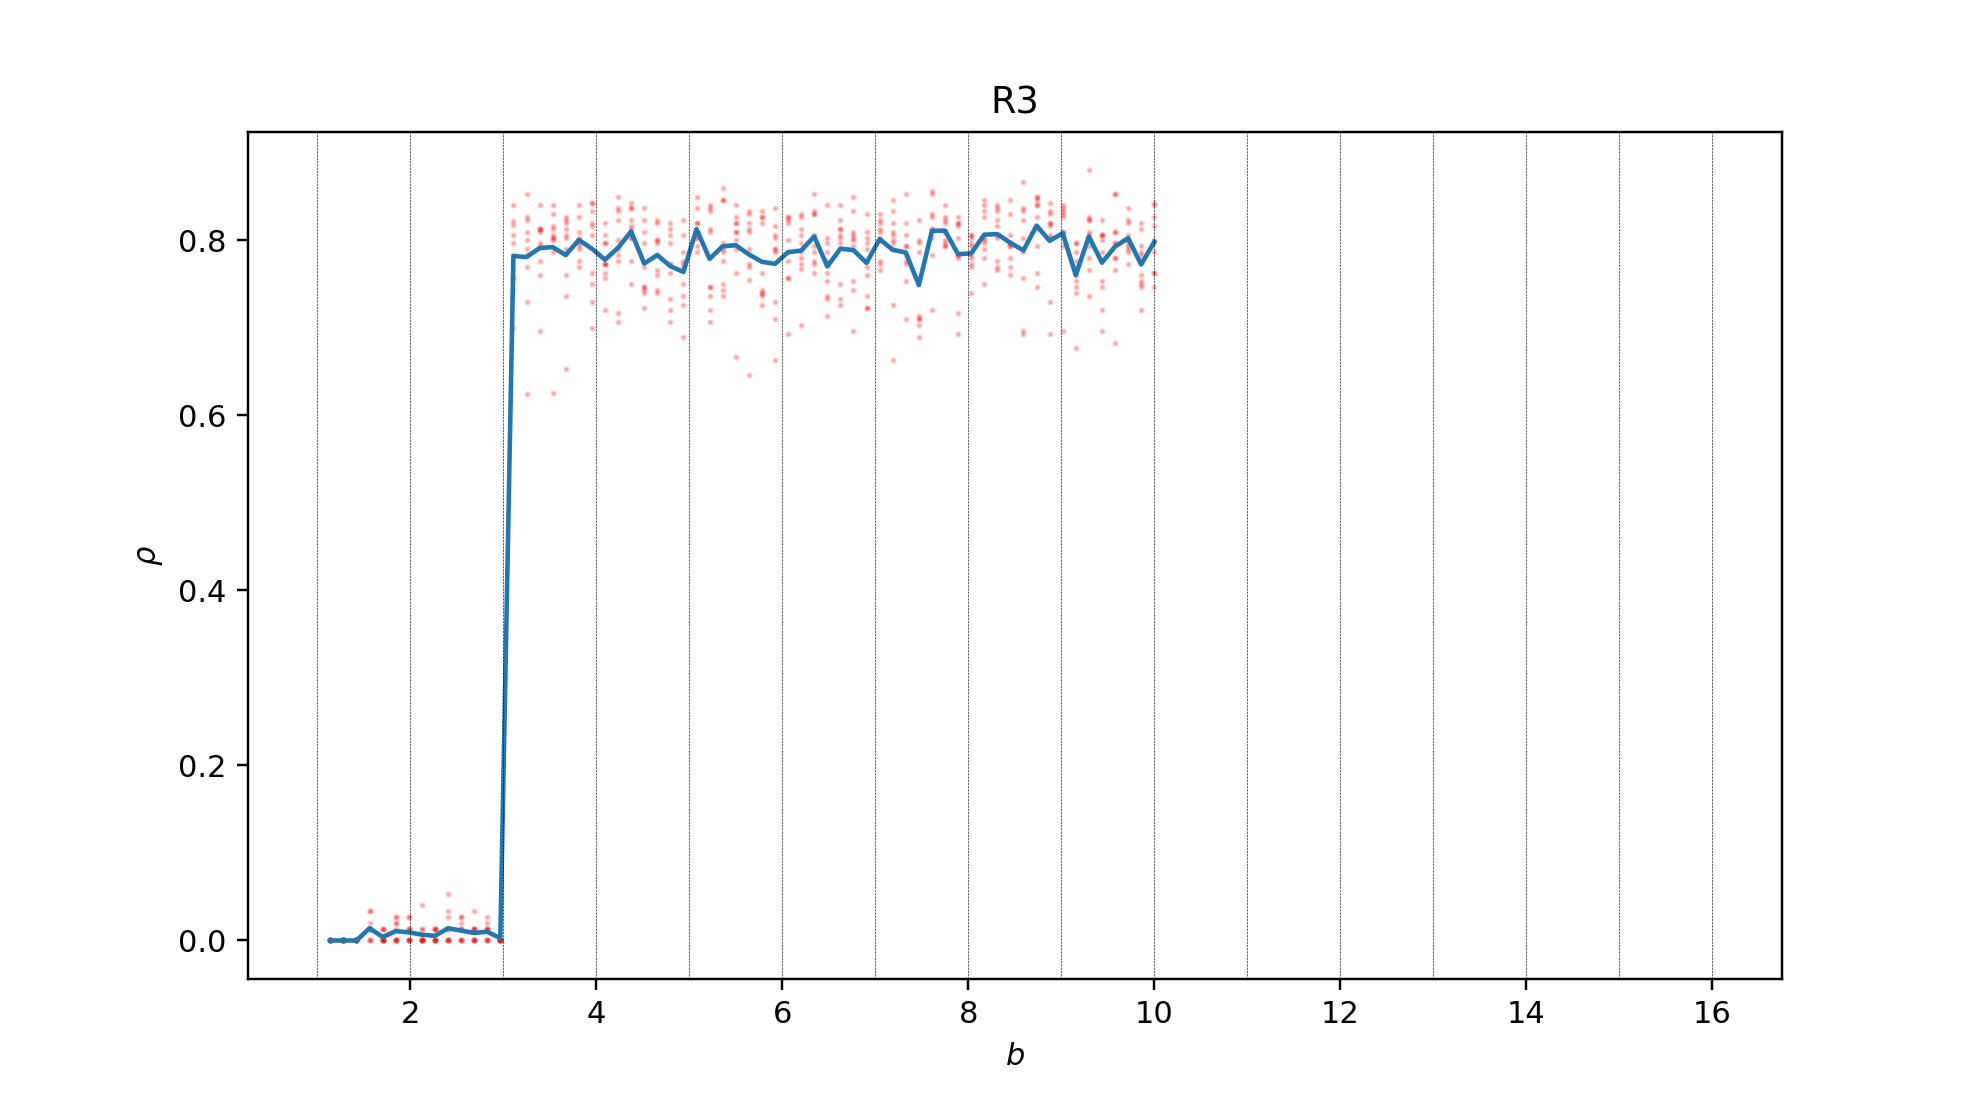

In [23]:
run_and_draw('r3_single', 'single', r_graphs(10, {3 : 300}), 1000, 200, 'R3')

time elapsed = 135.42779684066772
Written to /home/zhuk1996/data/r4_single.pkl
overall time = 2.263793357213338 mins


<IPython.core.display.Javascript object>


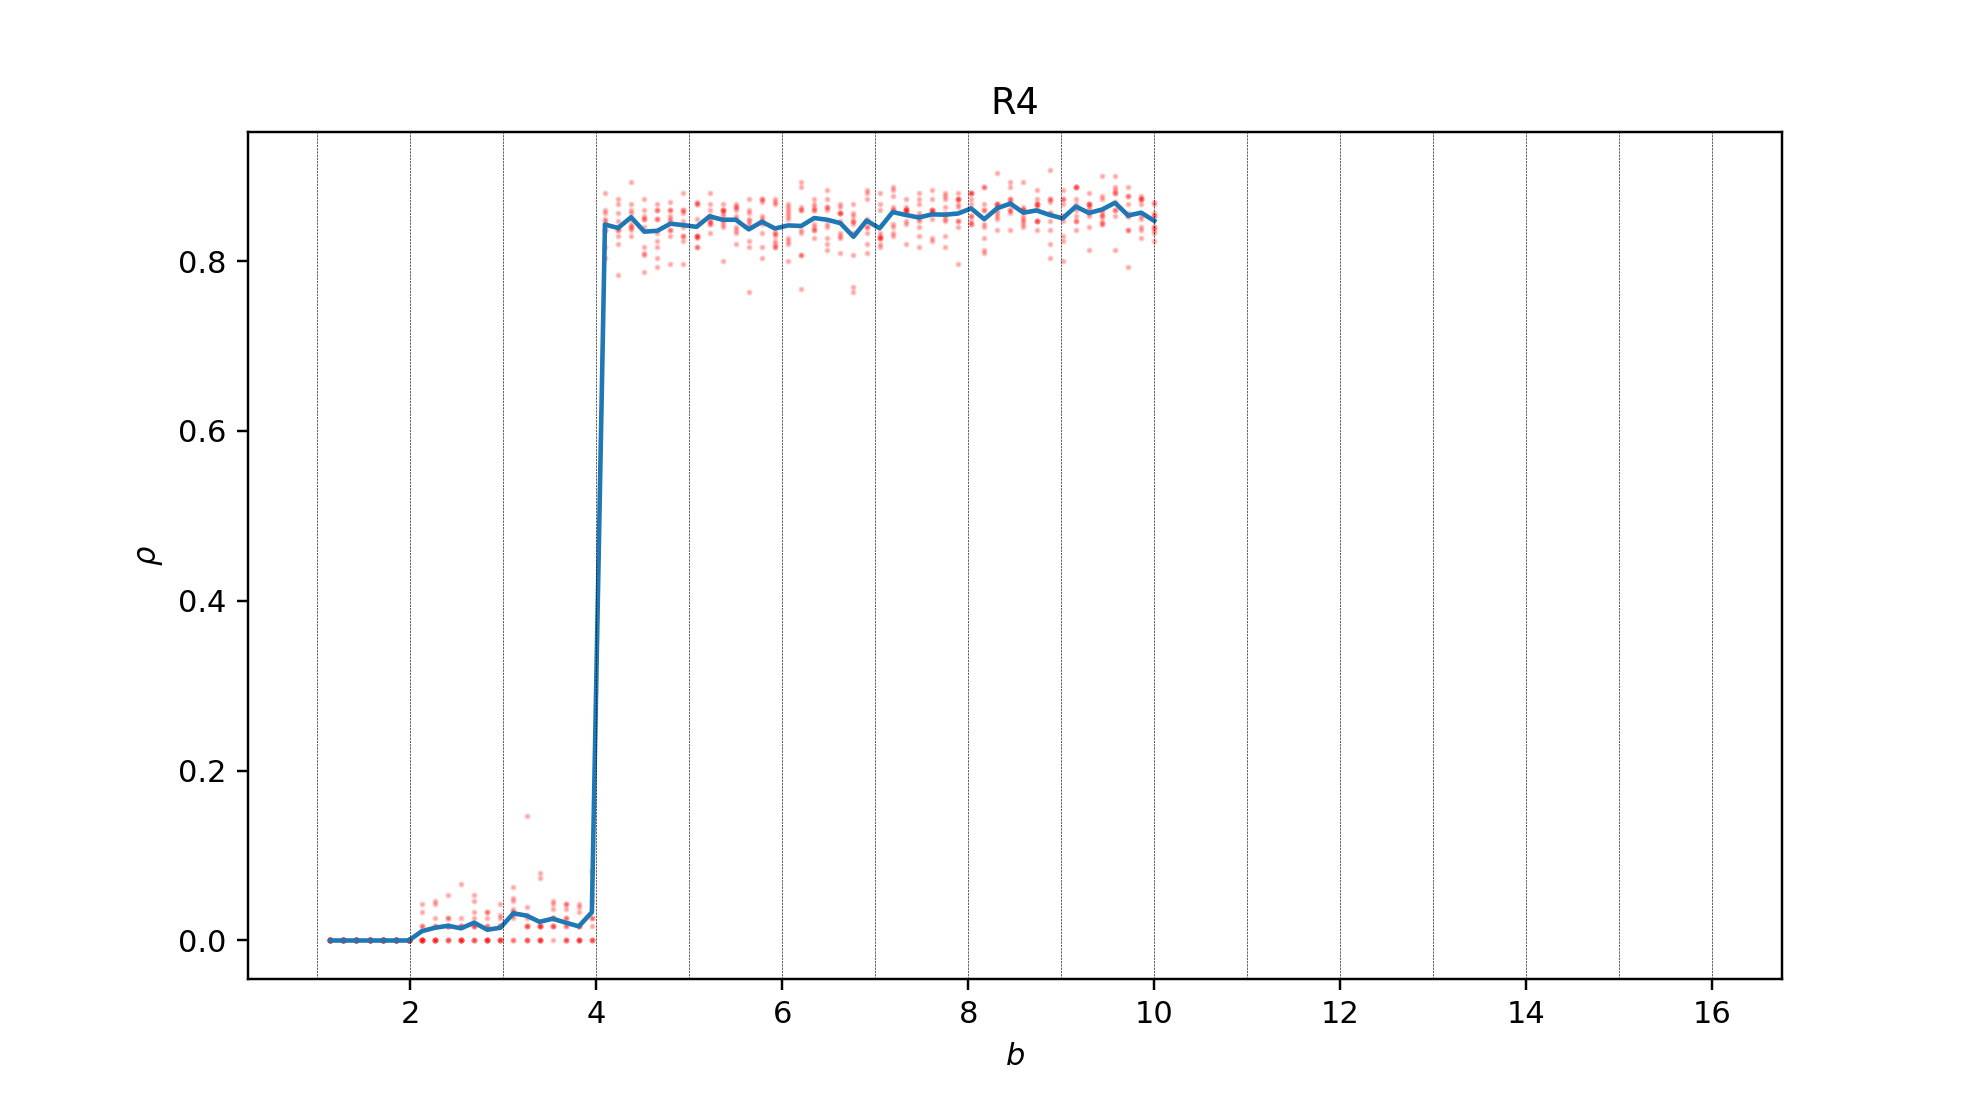

In [25]:
run_and_draw('r4_single', 'single', r_graphs(10, {4 : 300}), 1000, 200, 'R4')

<IPython.core.display.Javascript object>


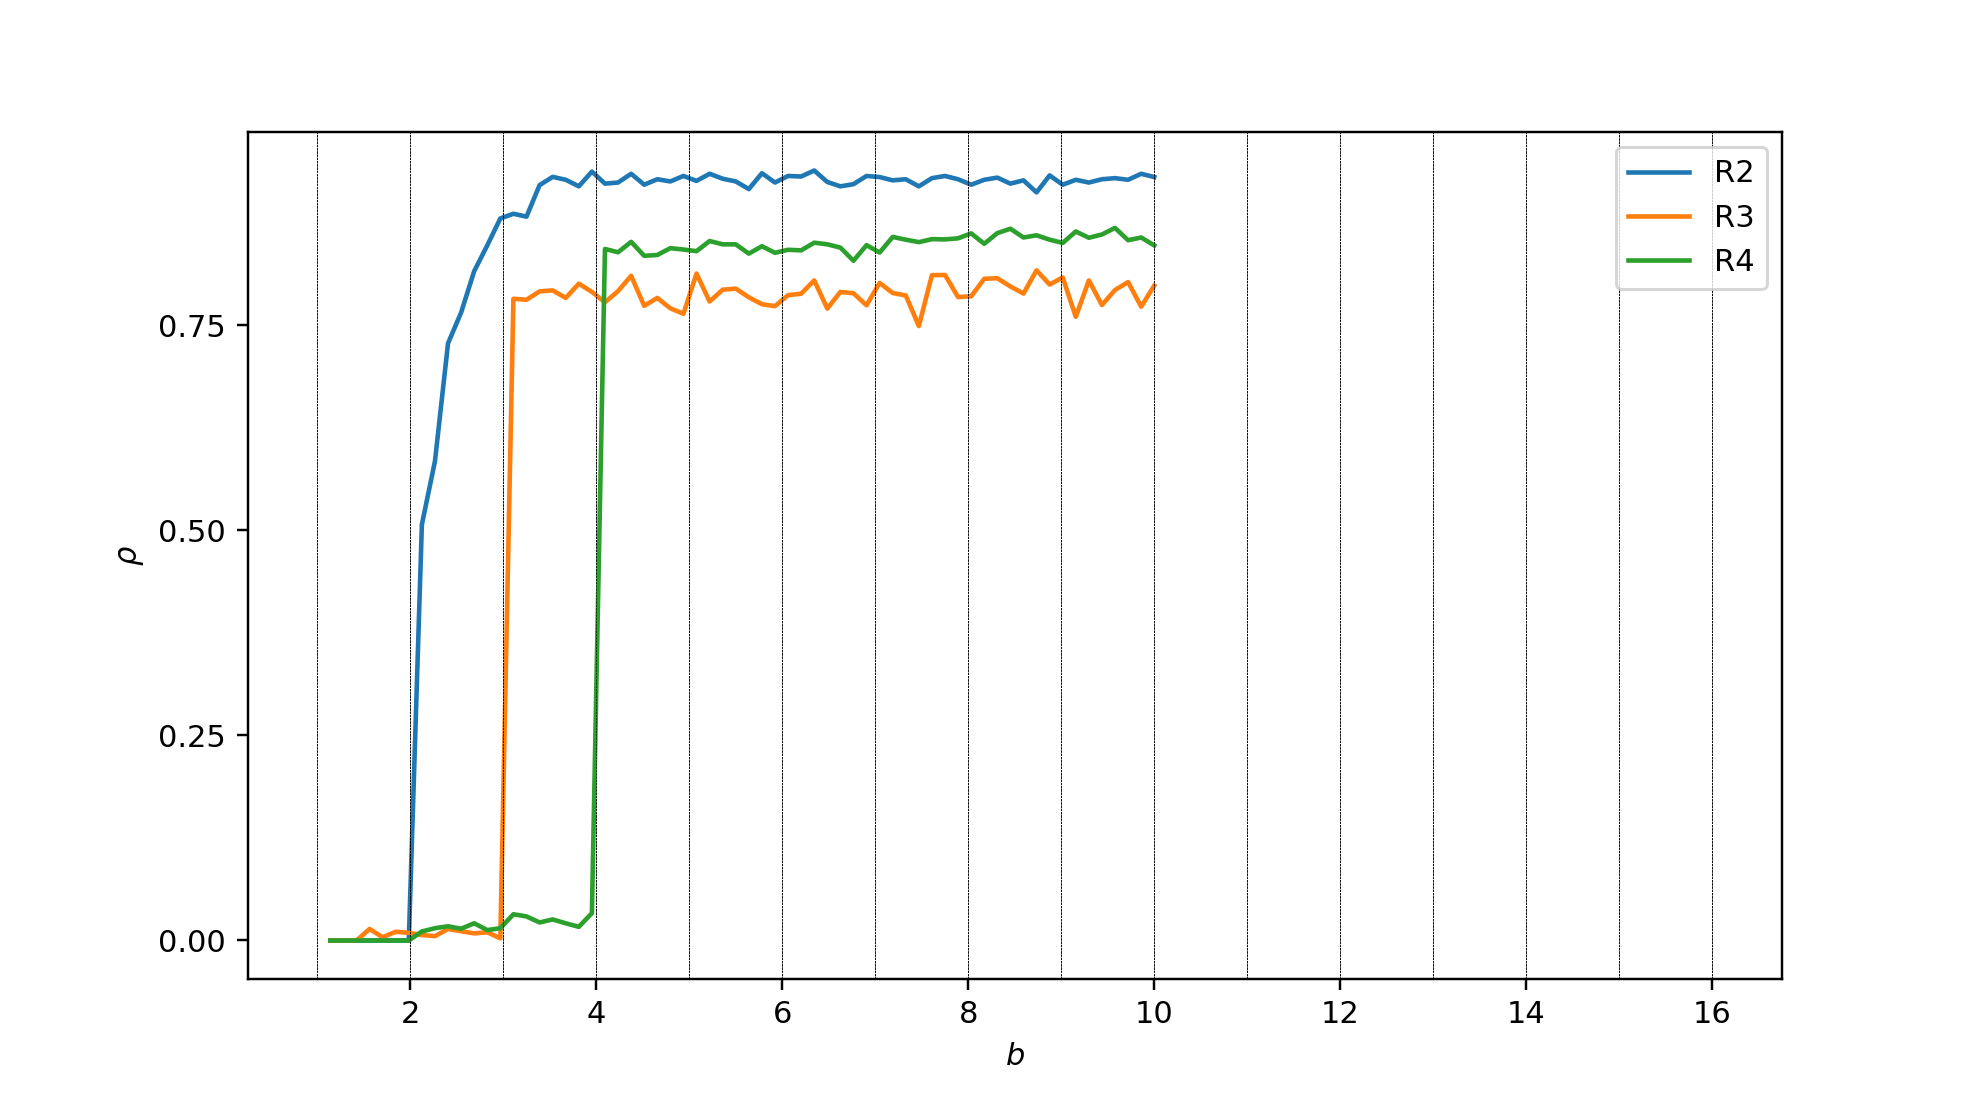

In [16]:
several(bs, ['r2_single', 'r3_single', 'r4_single'], 200, ['R2', 'R3', 'R4'])

time elapsed = 213.67891001701355
Written to /home/zhuk1996/data/r23_single.pkl
overall time = 3.5689005335172017 mins


<IPython.core.display.Javascript object>


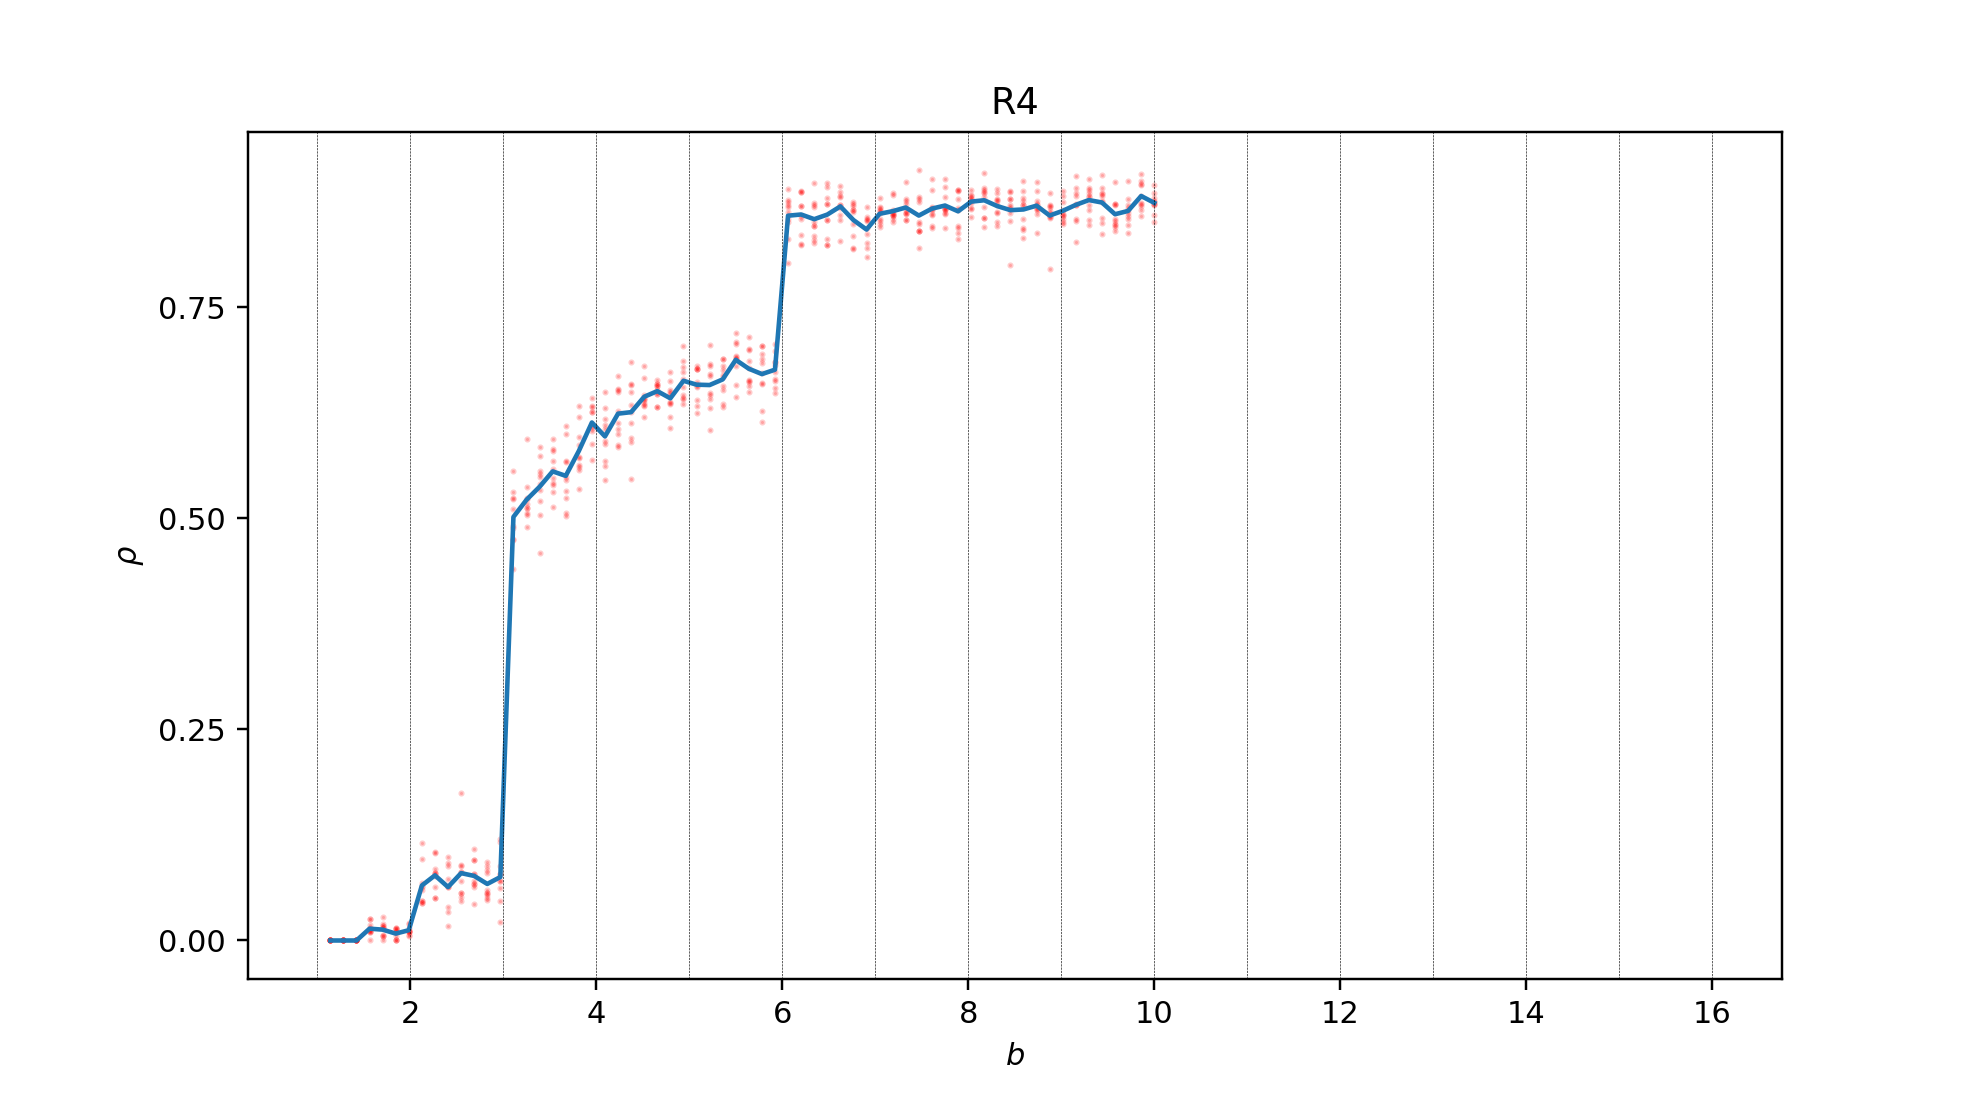

In [17]:
run_and_draw('r23_single', 'single', r_graphs(10, {2:300, 3:300}), 1000, 200, 'R23 Single')

time elapsed = 243.619615316391
Written to /home/zhuk1996/data/r23_diverse.pkl
overall time = 4.068007270495097 mins


<IPython.core.display.Javascript object>


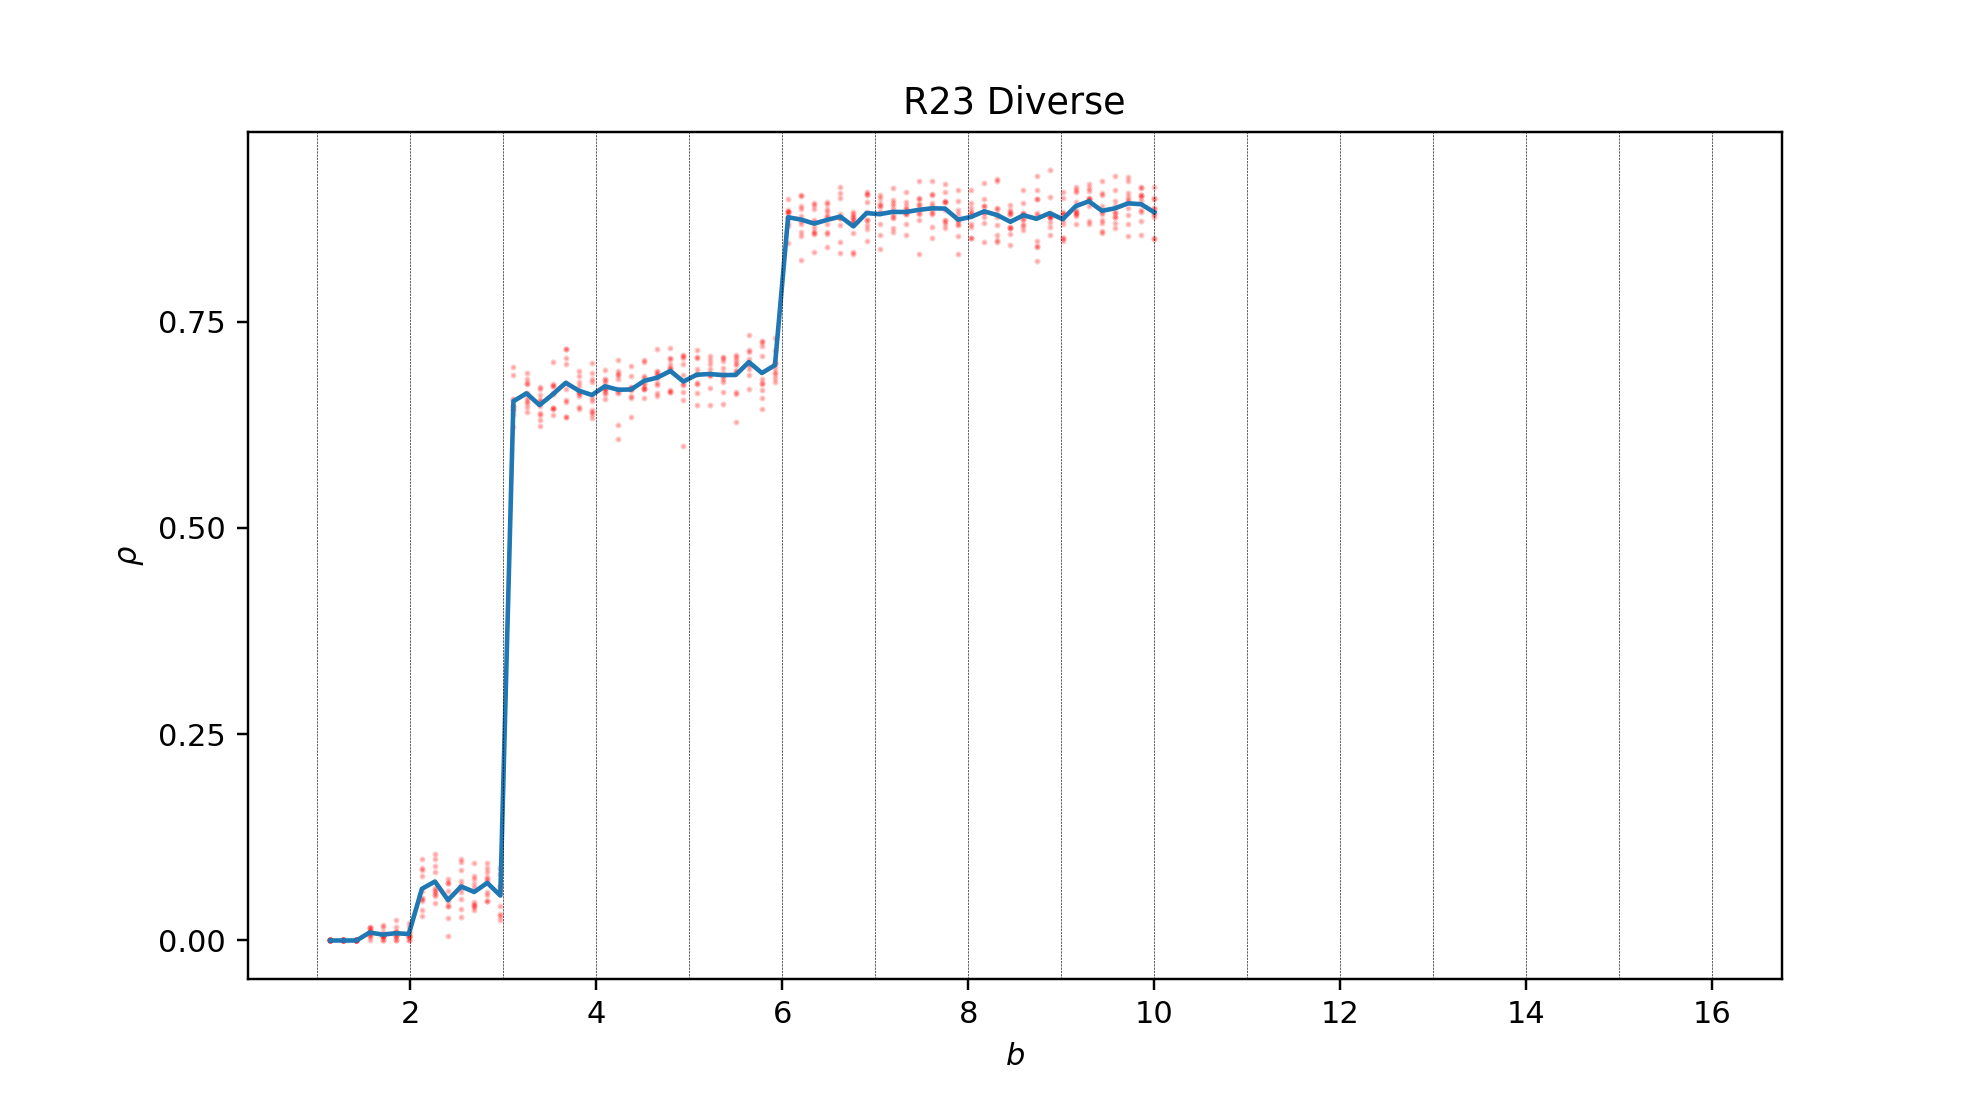

In [18]:
run_and_draw('r23_diverse', 'fun', r_graphs(10, {2:300, 3:300}), 1000, 200, 'R23 Diverse')

<IPython.core.display.Javascript object>


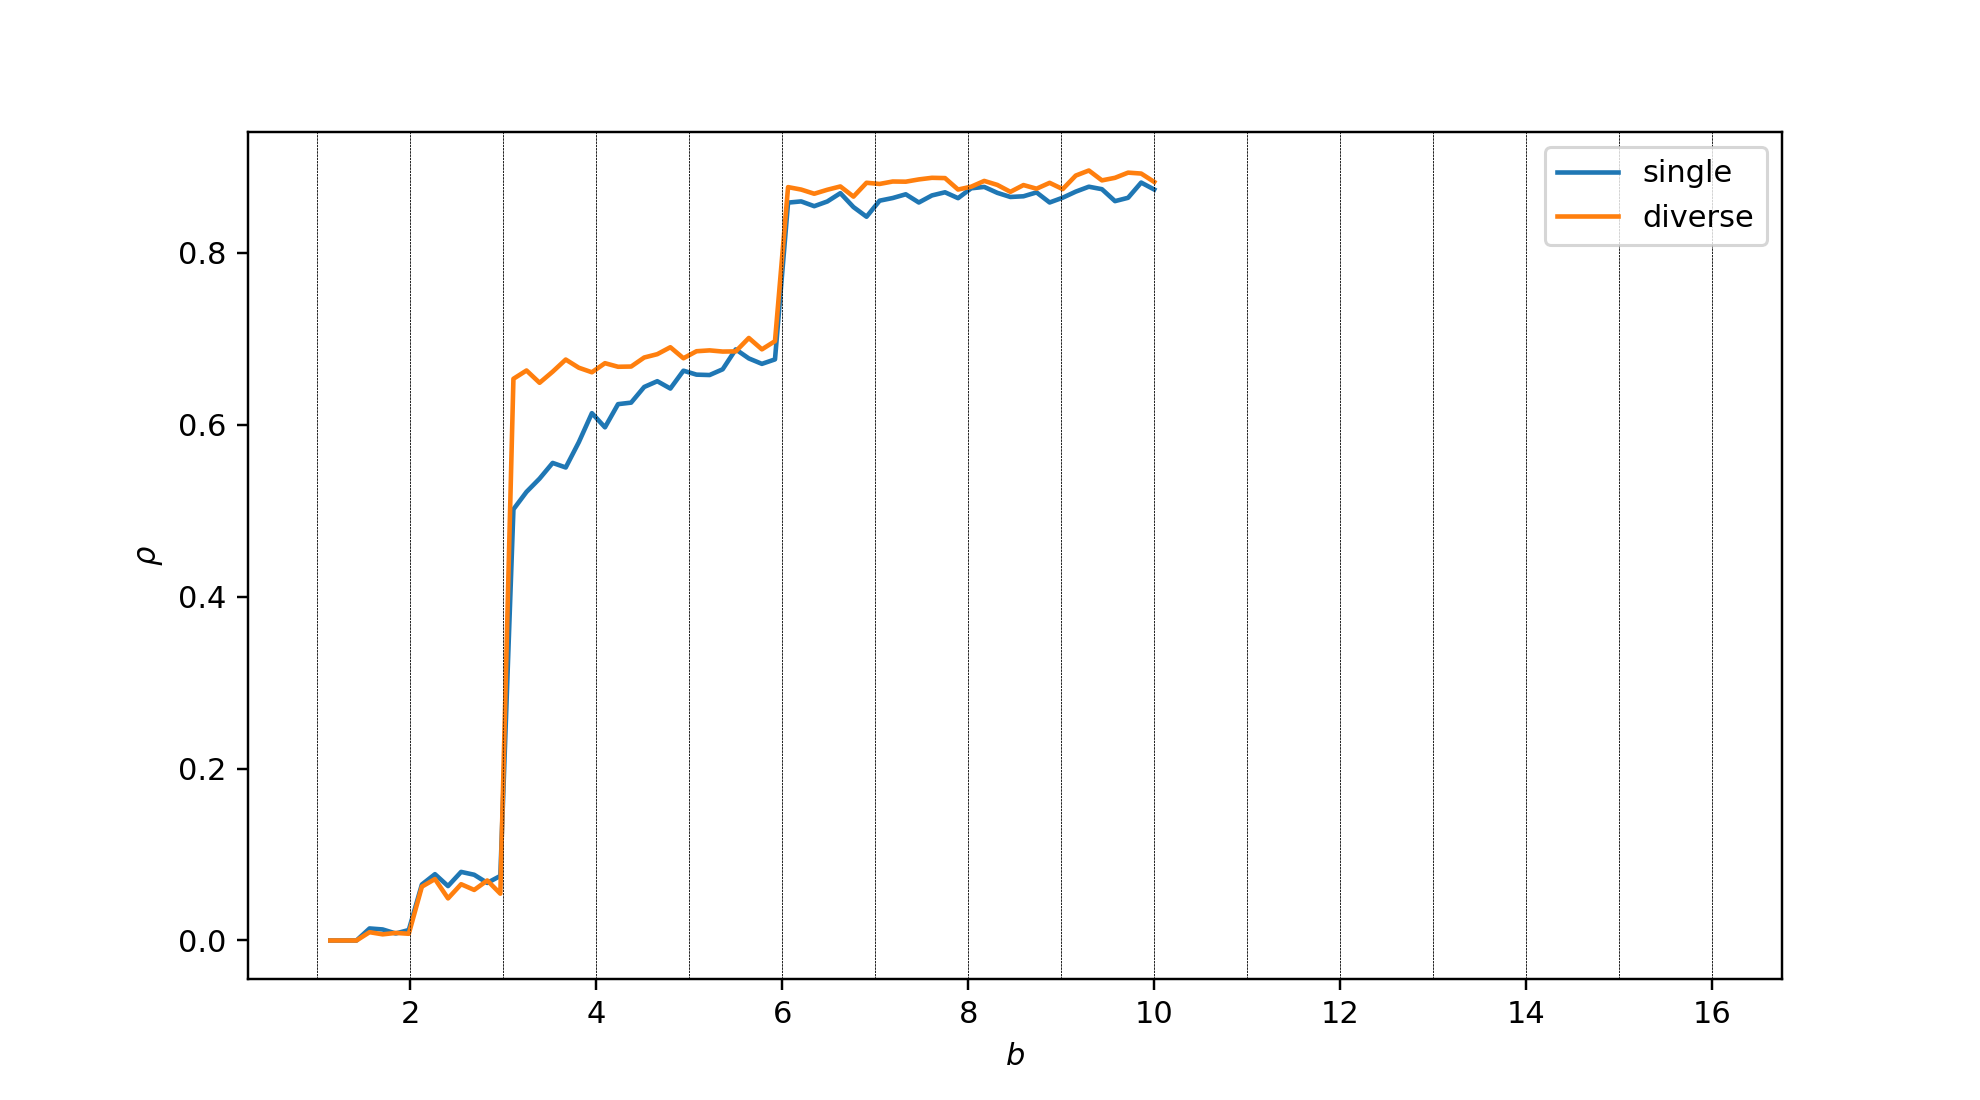

In [20]:
several(bs, ['r23_single', 'r23_diverse'], 200, ['single', 'diverse'])

In [ ]:
run_and_draw('assortativity_r35_-', 'fun', r_graphs(10, {3: 300, 5: 300}, -1000), 10000, 1000, 'R(3: 300, 5: 300) -')

In [ ]:
run_and_draw('assortativity_r35_+', 'fun', r_graphs(10, {3: 300, 5: 300}, +1000), 10000, 1000, 'R(3: 300, 5: 300) +')

In [ ]:
run_and_draw('assortativity_r35_0', 'fun', r_graphs(10, {3: 300, 5: 300}, 0), 10000, 1000, 'R(3: 300, 5: 300) 0')

<IPython.core.display.Javascript object>


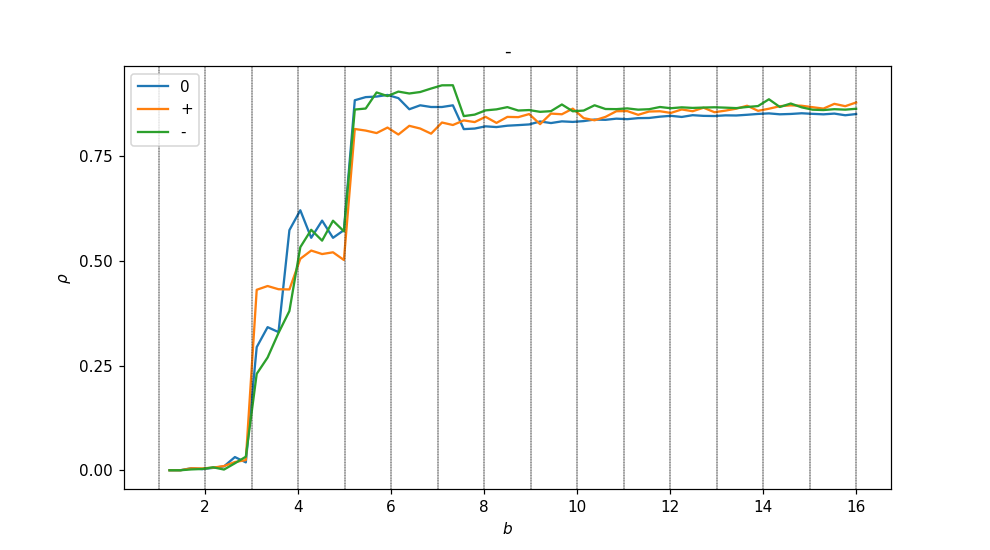

In [49]:
several(bs, ['assortativity_r35_0', 'assortativity_r35_+', 'assortativity_r35_-'],
       1000, ['0', '+', '-'])

In [ ]:
run_and_draw('assortativity_er_0', 'fun', er_graphs(10, 0), 10000, 1000, 'ER 0')

In [ ]:
run_and_draw('assortativity_er_+', 'fun', er_graphs(10, +10000), 10000, 1000, 'ER +')

In [ ]:
run_and_draw('assortativity_er_-', 'fun', er_graphs(10, -10000), 10000, 1000, 'ER -')

In [ ]:
several(bs, ['assortativity_er_0', 'assortativity_er_+', 'assortativity_er_-'],
       1000, ['0', '+', '-'])